# Block rewards

In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

Indlæser krævet pakke: viridisLite



In [2]:
#install.packages("BiocManager")
#BiocManager::install("rhdf5")
library(rhdf5)

R header:

In [3]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
#devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(size=17)
                # text=element_text(family="Arial")
                ) 


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis



In [4]:
# remove.packages("ptdalgorithms")

In [5]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [6]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [7]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [8]:
# Rcpp::sourceCpp("./timeinhom-kingman.cpp")

# Plotting

In [9]:
source("plot_functions.R")

In [10]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

In [11]:
plot_sfs <- function(graph, rewards) {
    sfs <- apply(rewards, 1, function(x) expectation(graph, x))
    data.frame(
      ton=seq(1,length(sfs)),  
      brlen=sfs
      ) %>% ggplot(aes(x=ton, y=brlen, fill=ton)) + 
      geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + 
          scale_x_continuous(breaks = 1:(dim(rewards)[1])) +
          theme(legend.position = "none") + labs(x='nr descendants') +
          labs(y = "Total branch length", x = "Number of descendants") +
          despine
}
                 
get_cov_mat <- function(graph, rewards) {
    n <- nrow(rewards)
    cov_mat <- matrix(nrow=n,ncol=n)
    for (i in 1:(n)) {
        for (j in 1:(n)) {
            cov_mat[i, j] <- covariance(graph, rewards[i,], rewards[j,])
        }
    }
    return(cov_mat)
}
                  
plot_cov_mat <- function(cov_mat) {
   
    df <- as.data.frame(cov_mat)
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
    df$ton1 <- as.character(df$ton1)
    df$ton2 <- gsub("V","",as.character(df$ton2))
    df$ton1 <- factor(df$ton1, levels=unique(df$ton1[order(as.numeric(df$ton1))]))
    df$ton2 <- factor(df$ton2, levels=unique(df$ton2[order(as.numeric(df$ton2))]))
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
        scale_y_discrete(labels= seq(1, nrow(cov_mat))) + 
        scale_fill_continuous(type = "viridis") + 
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

}

# Coalescent

## Block coalescent in R

In [12]:
block_coalescent <- function(n) {
      
    state_vector_length <- 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(0)
    initial_state[1] <- n
    add_edge(starting_vertex, create_vertex(graph, initial_state), 1)
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] == 1) {
        break
      }
      rate <- state[1] * (state[1] - 1) / 2
      child_state <- state
      child_state[1] <- child_state[1] - 1
      add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
      index <- index + 1
    }
    return(graph)
}

In [13]:
n <- 5
graph <- block_coalescent(n)
gam <- graph_as_matrix(graph)

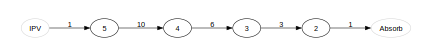

In [14]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

## SFS rewards for block coalescent

In [15]:
library("partitions")

# equivalence_classes <- function(n) {
#     p <- parts(n)
#     return(apply(p, 2, function(x) {x[x!=0]}))
# }

equivalence_classes <- function(n, size=0) {
    if (size != 0) {    
        m <- apply(parts(n), 2, function(x) {x[x!=0]})
        p <- m[lapply(m, length) == size]
    } else {
        p <- apply(parts(n), 2, function(x) {x[x!=0]})
    }
    return(p)
}

ton_counts <- function(p, n) {
    result <- rep(0, n)
    counts <- table(p)
    for (i in seq(n)) {
        c <- counts[names(counts)==i]
        if (length(c)) {
            result[i] <- c
        }
    }
    return(result)
}

multinom <- function(params) {
    if (length(params) == 1) {
        return(1)
    }
    return(choose(sum(params), params[length(params)]) * multinom(params[-length(params)]))
}

In [16]:
# coalescent_reward_matrix <- function(n) {
#     rewards <- matrix(0, n, n)
#     for (p in equivalence_classes(n)) {
#         counts <- ton_counts(p, n)
#         rewards[length(p), ] <- rewards[length(p), ] + counts * multinom(counts)
#     }
#     rewards <- rewards[-1, -ncol(rewards)]
#     if (n == 2) {
#         stopifnot(0, "NOT IMPLEMENTED")
#         scale <- 2/sum(rewards)
#         rewards <- rewards * scale
#         rewards <- c(0, rewards, 0)
#     } else {
#         scale <- (2:n)/apply(rewards, 1, sum)
#         rewards <- rewards * scale
#         rewards <- t(rewards)[, ncol(rewards):1]
#         rewards <- cbind(rep(0, nrow(rewards)), rewards, rep(0, nrow(rewards)))
#     }
#     return(rewards)        
# }
# rewards <- coalescent_reward_matrix(5)
# print(rewards)
# expectation(graph, rewards[3, ])

In [17]:
get_block_rewards <- function(n, l) {
    # a column in the matrix computed by get_block_rewards
    rewards <- matrix(0, n)
    for (p in equivalence_classes(n, size=l)) {
        counts <- ton_counts(p, n)
        rewards = rewards + counts * multinom(counts)
    }

    rewards <- rewards[-length(rewards)]
    if (sum(rewards) > 0) {
        scale <- l/sum(rewards)
        rewards <- rewards * scale
    }
    rewards <- c(0, rewards)
    return(matrix(rewards))
}
get_block_rewards(5, 3)

0.0
1.5
1.0
0.5
0.0


In [18]:
tensor_dims <- c(n, vertices_length(graph))
reward_fun <- get_block_rewards

reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(n, vertex_at(graph, i)$state))))
rewards <- array(unlist(reward_list), dim=tensor_dims)
rewards

0,0,0,0.0,0.0,0
0,5,3,1.5,0.5,0
0,0,1,1.0,0.5,0
0,0,0,0.5,0.5,0
0,0,0,0.0,0.5,0


In [19]:
expectation(graph, rewards[4, ])

[1] 0.6666667

## Precompute and cache as HDF5

Precompute rewards for a range of sample sizes:

In [23]:
# to_delete <- c()#70:80
# if (length(to_delete) > 0) {
#     h5f <- H5Fopen("../coal_block_rewards.h5")
#     for (sample_size in to_delete) {
#         name <- paste("coalescent/", sample_size, sep="")
#         if (H5Lexists(h5f, name)) {
#             h5delete(h5f, name=name)                          
#         }
#     }
#     H5Fclose(h5f)
# }

In [ ]:
reward_fun <- get_block_rewards

coal_block_rewards_h5_file <- "../coal_block_rewards.h5"
if (!file.exists(coal_block_rewards_h5_file)) {
    h5createFile(coal_block_rewards_h5_file)
    h5createGroup(coal_block_rewards_h5_file, "coalescent")
}
h5f <- H5Fopen(coal_block_rewards_file)
for (sample_size in 50:100) {
    name <- paste("coalescent/", sample_size, sep="")
    if (H5Lexists(h5f, name)) {
        next
    }
    graph <- block_coalescent(sample_size)
    tensor_dims <- c(sample_size, vertices_length(graph))    
    reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(sample_size, vertex_at(graph, i)$state))))
    rewards <- array(unlist(reward_list), dim=tensor_dims)
    # h5delete(h5f, name = paste("coalescent/", sample_size, sep=""))                          
    h5write(rewards, h5f,
            # file="block_coal_rewards.h5", 
            name=paste("coalescent/", sample_size, sep=""))
    # print(sample_size)
    # flush.console()
}
H5Fclose(h5f)
#h5closeAll()

In [ ]:
rewards <- h5read("../coal_block_rewards.h5", name=paste("coalescent/", sample_size, sep=""))
sfs_expectation <- apply(rewards, 1, function(x) expectation(graph, x))
                         

## Cached computation of SFS

In [339]:
# library(parallel)

# redo_sfs_rewards <- TRUE

# if (redo_sfs_rewards) {
#     v <- 3:20
#     n_list <- as.list(v)
#     names(n_list) <- v
#     sfs_rewards <- mclapply(n_list, coalescent_reward_matrix, mc.cores=detectCores())
#     saveRDS(sfs_rewards, file="sfs_rewards.RData")
# } else {
#     sfs_rewards <- readRDS(file="sfs_rewards.RData")
# }
# rewards <- sfs_rewards[[as.character(n)]]
# sfs_expectation <- apply(rewards, 1, function(x) expectation(graph, x))
# sfs_expectation

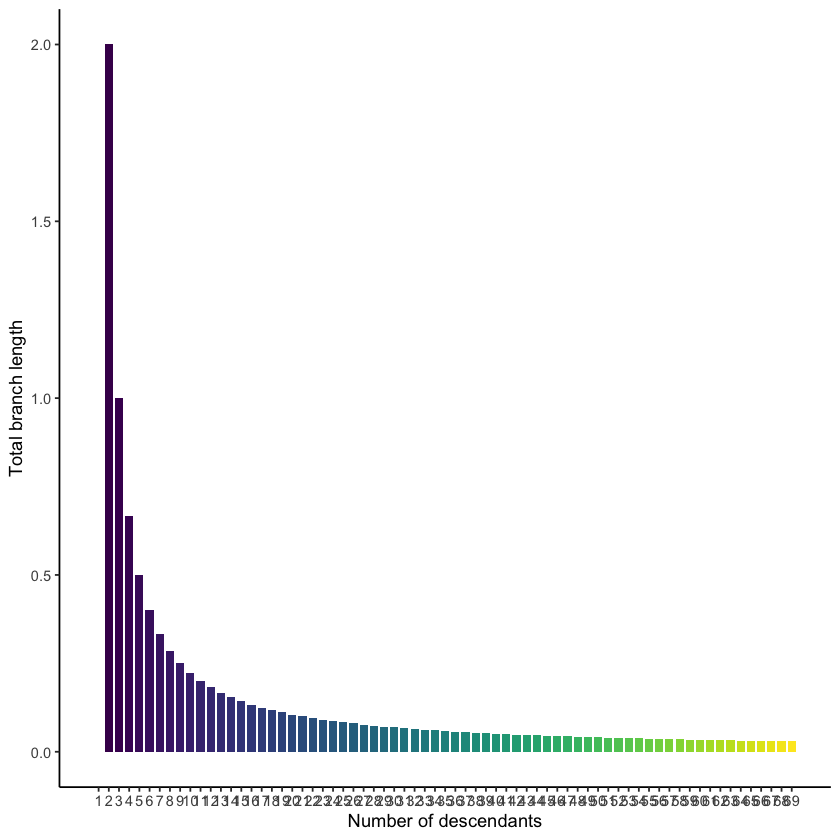

In [20]:
sfs_rewards <- function(graph, sample_size) {
    name <- paste("coalescent/", sample_size, sep="")
    h5f <- H5Fopen("../coal_block_rewards.h5")
    if (H5Lexists(h5f, name)) {
        rewards <- h5read(h5f, name=paste("coalescent/", sample_size, sep=""))
    } else {
        tensor_dims <- c(sample_size, vertices_length(graph))    
        reward_list <- lapply(1:vertices_length(graph), 
                              function(i) do.call(reward_fun, as.list(c(sample_size, vertex_at(graph, i)$state))))
        rewards <- array(unlist(reward_list), dim=tensor_dims)
        h5write(rewards, 
                h5f, 
                name=paste("coalescent/", sample_size, sep=""))
    }
    H5Fclose(h5f)                              
    return(rewards)
}

graph <- block_coalescent(69)
rewards <- sfs_rewards(graph, 69)
plot_sfs(graph, rewards)            

In [58]:
sample_size <- 50
graph <- block_coalescent(sample_size)
rewards <- h5read(file="block_coal_rewards.h5", 
               name=paste("coalescent/", sample_size, sep=""))

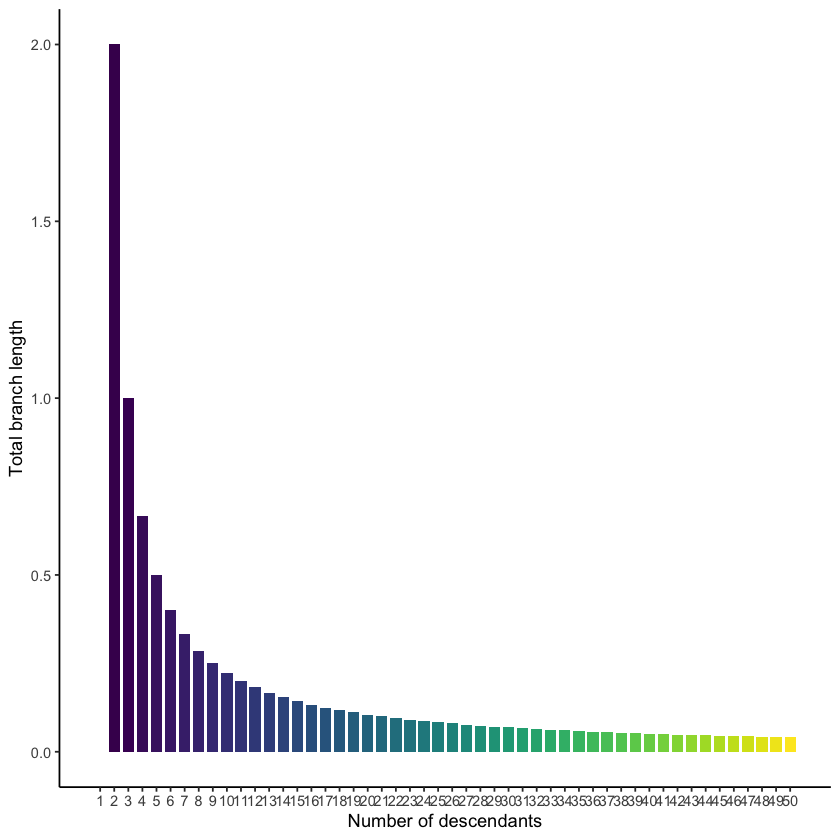

In [61]:
plot_sfs(graph, rewards) 

In [130]:
# for (n in 80:100) {
#     start <- proc.time()[3]
#     rewards <- get_block_rewards(n)
#     end <- proc.time()[3]
#     print(c(n, (end - start)[['elapsed']]))
#     flush.console()
# }

Compute the first moments for each "ton" for a number of samples:

In [343]:
nr_moments <- 10
sfs_moments <- data.frame(apply(rewards, 1, function(x) moments(graph, nr_moments, x)))
row.names(sfs_moments) <- 1:nr_moments
names(sfs_moments) <- 1:(sample_size-1)
sfs_moments

,1,2,3,4,5,6,7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.000000e+00,1.000000,0.6666667,0.5000000,0.4000000,0.3333333,0.2857143
2,4.571429e+00,1.206349,0.5790476,0.3555102,0.2510658,0.1950113,0.1632653
3,1.175510e+01,1.714286,0.6293437,0.3361224,0.2216676,0.1678005,0.1399417
4,3.358601e+01,2.816974,0.8300391,0.4024233,0.2558018,0.1918954,0.1599334
5,1.055560e+02,5.273729,1.2967891,0.5880475,0.3666063,0.2741656,0.2284762
6,3.619063e+02,11.111957,2.3537585,1.0193923,0.6291395,0.4700066,0.3916735
7,1.344224e+03,26.083899,4.8848375,2.0501088,1.2587268,0.9400159,0.7833471
8,5.376894e+03,67.624569,11.4383549,4.6989110,2.8774309,2.1486089,1.7905076
9,2.304383e+04,192.200692,29.8838264,12.0995646,7.3994005,5.5249948,4.6041624


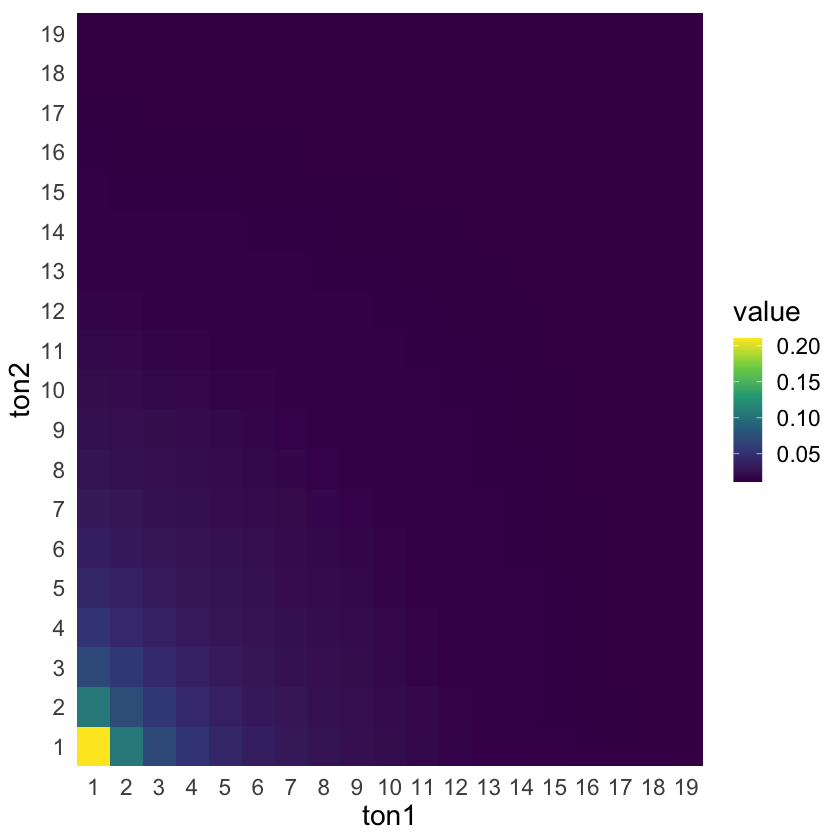

In [344]:
plot_cov_mat(get_cov_mat(graph, rewards))

# ARG

## Block ARG in R

In [645]:
block_arg <- function(n) {
      
    state_vector_length <- 4
    # state_vector_length <- 3
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(n, n, n, 0)
    # initial_state <- c(n, n, n)
    add_edge(starting_vertex, find_or_create_vertex(graph, initial_state), 1)
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state

        
      if (state[1] <= 1 && state[2] <= 1 && (state[3] == 1 ) ) {
      # if (state[1] <= 1 && state[2] <= 1) {
        index <- index + 1 
        next
      }

     # PROBLEM: WE KEEP TRACK OF HOW MANY THAT HAVE LINKED BACK TOGETHER, 
     # BUT NOT IF THESE HAVE LINKED APART AGAIN, SO WE DO NOT HAVE A WAY TO 
     # TO DETERMINE IF THE LAST TWO L1 AND L2 ARE LINKED OR NOT...

        
      l1 <- state[1] - state[3]
      l2 <- state[2] - state[3]
      l1l2 <- state[3]
      l1_l2 <- state[4]
      # prop_sample_linked <- state[4] / n

      if (l1 >= 1) {
        if (l1 >= 2 || l1l2 >= 1) {
            rate <- (l1 * (l1 - 1) / 2) + l1*l1l2
            child_state <- state
            child_state[1] <- child_state[1] - 1
            add_edge(vertex, find_or_create_vertex(graph, child_state), rate) 
            
        }          
      }
      if (l2 >= 1) {
        if (l2 >= 2 || l1l2 >= 1) {
            rate <- (l2 * (l2 - 1) / 2) + l2*l1l2
            child_state <- state
            child_state[2] <- child_state[2] - 1
            add_edge(vertex, find_or_create_vertex(graph, child_state), rate) 
            
        }          
      }         
      if (l1-l1_l2 >= 1 && l2-l1_l2 >= 1) { # THE ONES ARE NEITHER LINKED OR RELINKED
        rate <- l1 * l2
        child_state <- state
        child_state[4] <- child_state[4] + 1
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)   
      }
      if (l1l2 >=2) {
        rate <- l1l2 * (l1l2 - 1) / 2
        child_state <- state
        child_state[1] <- child_state[1] - 1
        child_state[2] <- child_state[2] - 1
        child_state[3] <- child_state[3] - 1          
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)  
      }        

      # recombination
      if (l1l2 >=1) {        
        rate <- 5        # hardcoded recombination rate
        child_state <- state
        child_state[3] <- child_state[3] - 1
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)  
      }

      index <- index + 1 
    }
    return(graph)
}

n <- 3
graph <- block_arg(n)
vertices_length(graph)

[1] 73

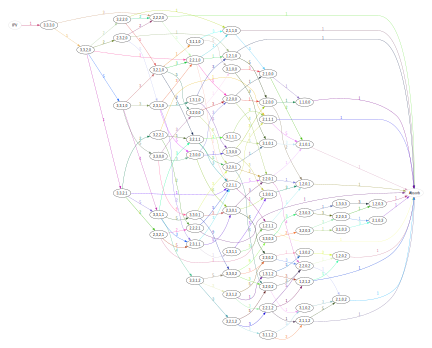

In [646]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, rainbow=TRUE)

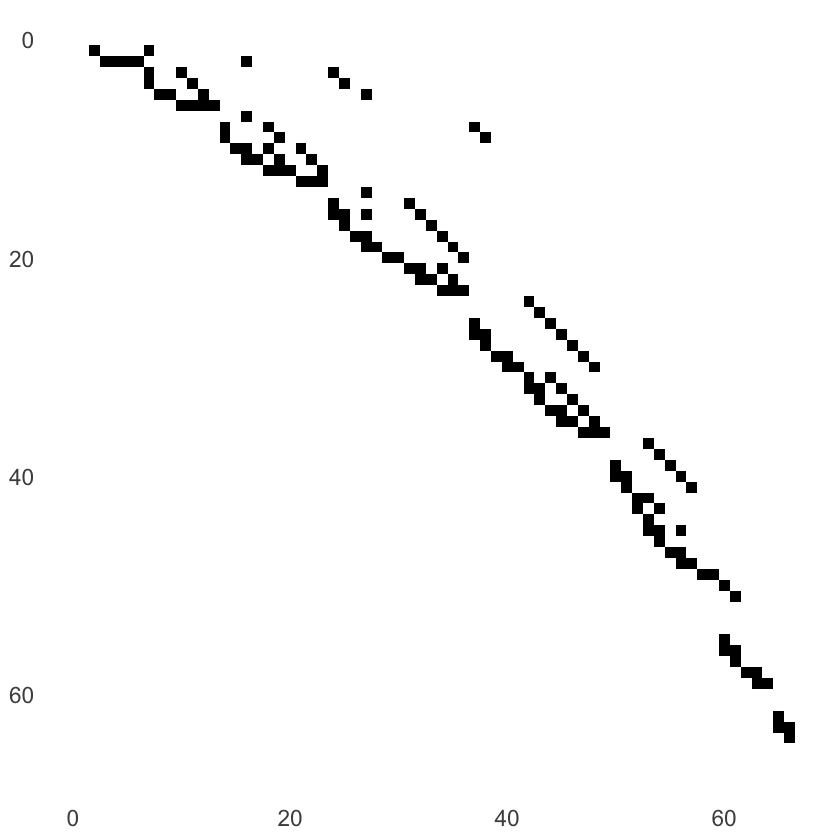

In [634]:
plot_sim <- function(graph)
{
    gam <- graph_as_matrix(graph)
    mat <- t(gam$SIM)
    mat <- matrix(as.integer(mat > 0), dim(mat))
    
    rownames(mat) <- 1:nrow(mat)
    colnames(mat) <- 1:ncol(mat)
    df <- as.data.frame(mat)
    df <- df %>% rownames_to_column('n') %>% gather('m', 'value', -c(n))
    df$n <- as.numeric(df$n)
    df$m <- as.numeric(df$m)
    ggplot(df, aes(n, m)) +
        geom_tile(aes(fill = value), show.legend = FALSE) + 
        scale_y_reverse() +
        scale_fill_gradient(low="white", high="black") +
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              text=element_text(size=17))
}

plot_sim(graph)

## 2D SFS rewards for block ARG

In [679]:
marg_tree_rewards <- function(n, l) {
    r <- rep(0, n)
    for (p in equivalence_classes(n, size=l)) {
        counts <- ton_counts(p, n)
        r <- r + counts * multinom(counts)
    }
    scale <- l / sum(r)
    r <- r * scale
    return(r)
}

          
# arg_state_reward <- function(n, locus1, locus2, linked, orig_linked) {
arg_state_reward <- function(n, locus1, locus2, linked, relinked) {

    l1 <- locus1 - linked
    l2 <- locus2 - linked

    rewards <- matrix(0, n+1, n+1)
    if (locus1 + locus2 == 0) {
        return(rewards)
    }
    part <- equivalence_classes(n, size=linked)
    print(part)
    for (l1_p in part) {
        for (l2_p in part) {
            for (a in l1_p) {
                for (b in l2_p) {
                    if (locus1 > 0)
                        rewards[a+1, b+1] <- rewards[a+1, b+1] + (1 - (linked / locus1)) * multinom(ton_counts(l1_p, n)) 
                    if (locus2 > 0)
                        rewards[a+1, b+1] <- rewards[a+1, b+1] + (1 - (linked / locus1)) * multinom(ton_counts(l2_p, n)) 

                        # (1 - orig_linked/n) * multinom(ton_counts(l1_p, n)) + 
                        # (1 - orig_linked/n) * multinom(ton_counts(l2_p, n)) 
                }
            }
        }
    }
    print(rewards)
    for (i in 1:length(part)) {
        p <- part[i][[1]]
        for (a in p) {
            if (locus1 > 0)
                rewards[a+1, a+1] <- rewards[a+1, a+1] + (linked / locus1) * multinom(ton_counts(p, n))
            if (locus2 > 0)
                rewards[a+1, a+1] <- rewards[a+1, a+1] + (linked / locus2) * multinom(ton_counts(p, n))

                # (orig_linked/n) * multinom(ton_counts(p, n)) + 
                # (orig_linked/n) * multinom(ton_counts(p, n)) 
        }
    }
print(rewards)
    # top_row = colSums(rewards)
    # left_col = rowSums(rewards)
    
    rewards[n+1, n+1] = 0

    if (sum(rewards) > 0) {
        scale <- linked / sum(rewards)
        rewards <- rewards * scale
    }
    
    if (l1 > 0) {
        rewards[1, ] <- rewards[1, ] + c(0, marg_tree_rewards(n, l1) )
        # rewards[1, ] <- top_row
    }
    if (l2 > 0) {
        rewards[, 1] <- rewards[, 1] + c(0, marg_tree_rewards(n, l2) )
        # rewards[, 1] <- left_col
    }


    
    return(rewards)
}

# IT SEEMS WE DO NOT GET VALUES IN THE LINKED PART OF THE MATRIX IF NR LINKED IS ONE... 

arg_state_reward(3, 3, 0, 0)
arg_state_reward(3, 3, 1, 0)

[[1]]
[1] 3

[[2]]
[1] 2 1

[[3]]
[1] 1 1 1

     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    0   20    5    5
[3,]    0    8    2    2
[4,]    0    4    1    1
     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    0   20    5    5
[3,]    0    8    2    2
[4,]    0    4    1    1


0,3,0,0
0,0,0,0
0,0,0,0
0,0,0,0


[[1]]
[1] 3

[[2]]
[1] 2 1

[[3]]
[1] 1 1 1

     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    0   40   13    9
[3,]    0   13    4    3
[4,]    0    9    3    2
     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    0   40   13    9
[3,]    0   13    4    3
[4,]    0    9    3    2


0,3,0,0
0,0,0,0
0,0,0,0
1,0,0,0


In [670]:
tensor_dims <- c((n+1), (n+1), vertices_length(graph))
reward_fun <- arg_state_reward
reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(n, vertex_at(graph, i)$state))))
rewards <- array(unlist(reward_list), dim=tensor_dims)
print(dim(rewards))
expectation(graph, rewards[4, 4, ])

[[1]]
[1] 1 1 1

     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    0    0    0    0
[3,]    0    0    0    0
[4,]    0    0    0    0
     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    0    6    0    0
[3,]    0    0    0    0
[4,]    0    0    0    0
[[1]]
[1] 2 1

     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    0    0    0    0
[3,]    0    0    0    0
[4,]    0    0    0    0
     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    0    4    0    0
[3,]    0    0    4    0
[4,]    0    0    0    0
[[1]]
[1] 2 1

     [,1]     [,2]     [,3] [,4]
[1,]    0 0.000000 0.000000    0
[2,]    0 1.333333 1.333333    0
[3,]    0 1.333333 1.333333    0
[4,]    0 0.000000 0.000000    0
     [,1]     [,2]     [,3] [,4]
[1,]    0 0.000000 0.000000    0
[2,]    0 4.000000 1.333333    0
[3,]    0 1.333333 4.000000    0
[4,]    0 0.000000 0.000000    0
[[1]]
[1] 3

     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    0    0    0    0
[3,]    0    0    0    0
[4,]    0 

[1] 0

In [671]:
exp_mat <- matrix(0, nrow=n+1,ncol=n+1)
for (i in 1:(n+1)) {
  for (j in 1:(n+1)) {
    exp_mat[i,j] <- expectation(graph, rewards[i, j, ])
  }
} 
exp_mat

0.0000000,1.09320747,0.84906684,0.7416427
1.0932075,0.52256944,0.01909722,0.0000000
0.8490668,0.01909722,0.14756944,0.0000000
0.7416427,0.00000000,0.00000000,0.0000000


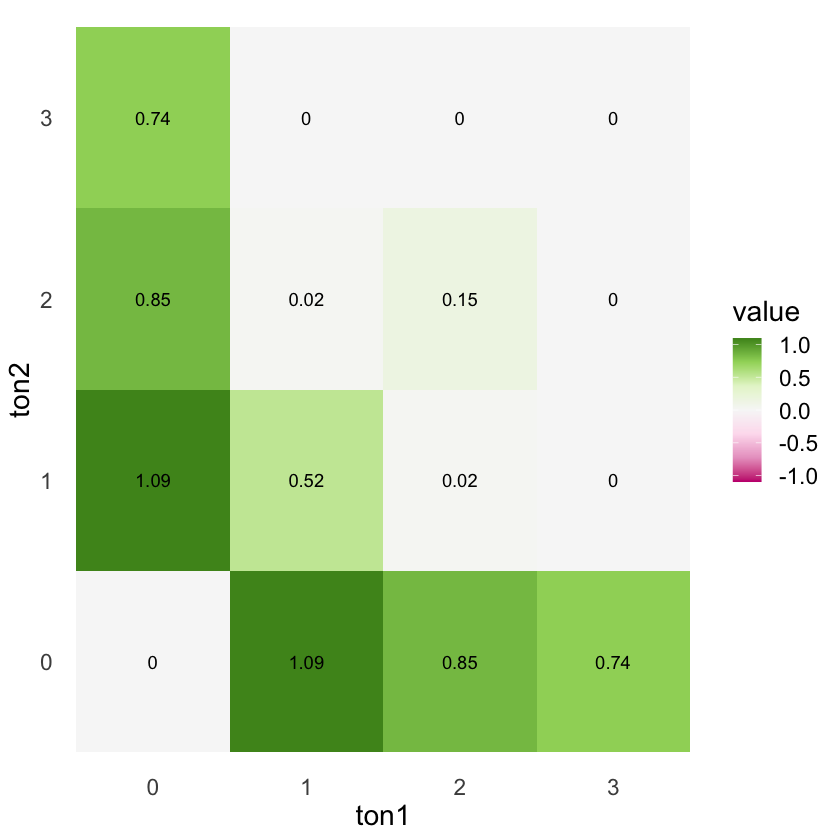

In [672]:
df <- as.data.frame(exp_mat) #%>% gather()
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
limit <- max(na.omit(abs(df$value))) * c(-1, 1)
ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
    geom_text(aes(label = round(value, 2))) +
    scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_fill_distiller(palette = 'PiYG',direction = 1, limit=limit) +
    theme_minimal() +
    theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))

In [560]:
exp_mat[, 1] / sum(exp_mat[, 1])

[1] 0.0000000 0.2822906 0.2206803 0.1750089 0.1410474 0.1809728

In [516]:
exp_mat[1, ] / exp_mat[, 1]

[1] NaN   1   1   1   1   1